# 42578 Project: Advanced Business Analytics
## Title: Bias-detection systems in job descriptions and exploratory analysis of underrepresented groups in the workforce
### Theme: AI for the betterment of society
#### Group members:

- Anna Matzen - s214978 
- Anne Moll-Elsborg - s214986
- Kalle Leander Johansen - s204099
- Paula Granlund - s215001

#### Date: May 2025

## Introduction
Extensive research demonstrates that organizations with diverse workforces consistently outperform their peers across virtually every metric. Diversity enriches all aspects of business, from front-line employees to executive leadership.

By welcoming a wide range of perspectives, working styles, and experiences, companies foster innovation, integration, and sustainable growth. Organizations that proactively cultivate and attract diverse talent position themselves for greater long-term success.

A balanced workforce begins with job advertisements that are free from unconscious bias. Employers who prioritize inclusive language demonstrate forward-thinking values and attract a broader, more diverse pool of qualified candidates.

Unconscious biases within job descriptions can inadvertently keep highly qualified candidates from applying. These biases commonly appear in both the language and format of job postings. By carefully reviewing and revising job advertisements, organizations can eliminate these barriers and ensure they appeal to all suitable applicants.

**Note:** *Unconscious bias* refers to implicit attitudes, stereotypes, or assumptions about certain groups of people that individuals hold without conscious awareness. These biases are shaped by personal experiences, cultural influences, and societal norms, and they can unintentionally influence decisions, behaviors, and interactions, often leading to unfair outcomes or discrimination even when people consciously believe in equality and fairness.

## Motivation and related studies
The study "Evidence That Gendered Wording in Job Advertisements Exists and Sustains Gender Inequality" by Danielle Gaucher and Justin Friesen, University of Waterloo, showed job adverts which included different kinds of gender-coded language to men and women and recorded how appealing the jobs seemed and how much the participants felt that they 'belonged' in that occupation. The research states that despite widespread egalitarian ideals, women remain underrepresented in male-dominated fields such as engineering, business leadership, and the natural sciences. 

The paper identifies job advertisements as an institutional-level factor that perpetuates gender inequality through subtle gendered wording, reinforcing gender stereotypes and discouraging women from applying. Two additional findings are worth to highlight:

- Empirical evidence demonstrates that job ads for male-dominated occupations systematically contain more masculine-themed words (e.g., “leader,” “competitive,” “dominant”) than advertisements in female-dominated areas. 
- No corresponding increase in feminine wording (“support,” “understand,” “interpersonal”) is observed in advertisements for female-dominated occupations, suggesting an asymmetry aligned with social dominance theory rather than social role theory.

From a practical perspective, the results suggest the importance of consciously revising job advertisements to remove masculine biases, thus promoting gender diversity and inclusion in workplaces.

**By now, it should be clear why recognizing and addressing bias in hiring practices is essential - and why eliminating unconscious bias must begin from the earliest stage: the job description itself.**

## Exploratory analysis
In the previous section, it was mentioned that “women remain underrepresented in male-dominated fields.” This statement is originally based on a U.S. analysis from 2011, with many recent studies continuing to support this observation. Given the critical importance of this assumption for the current study, this section will further examine it by analyzing and comparing gender distributions across education and employment in Denmark, using data from 2021.

In [ ]:
# THIS IS WHERE TO BEGIN CODING
## The purpose is to:
## 1) Detect if there are sectors where the dominant gender in the education differ from the dominant gender in the workforce (employment)
## 2) Check the above assumption about underrepresentation

In [1]:
# Load Packages
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.stem import PorterStemmer
import torch
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

#nltk.download('punkt')
#nltk.download('punkt_tab')

/Users/kalleleander/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kalleleander/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
## Gender distribution in work

# Replace this with the actual name of your Excel file
path = "CSVfiles/2025411141143535010615LIGEAI3.xlsx" 

# Read the Excel file from Desktop
df = pd.read_excel(path)

# Mapping categories
target_groups = {
    "Landbrug, skovbrug og fisker": [
        "Growing", "Raising", "Plant propagation", "Hunting", "Silviculture", "Logging",
        "Gathering", "Support services to forestry", "Marine fishing", "Freshwater fishing",
        "Marine aquaculture", "Freshwater aquaculture", "farming", "textile", "Fish"
    ],
    "Industri, råstofindvinding og forsyningsvirksomhed": [
        "Mining", "Extraction", "Quarrying", "Manufacture", "Processing", "Production",
        "Refining", "Casting", "Forging", "Repair of fabricated metal products",
        "Electricity", "Gas", "Water", "Sewerage", "Waste", "Remediation", "textile", "textiles", "leather", "wood", "Printing", "stone", "cold",
        "metals", "Machining", "Building", "manufacturing", "Repair", "drilling", "wall", "Bricklayers", "Tyre",  
    ],
    "Bygge og anlæg": [
        "Construction", "Demolition", "Site preparation", "Electrical installation",
        "Plumbing", "Joinery", "Roofing", "Painting", "Glazing", "Building completion"
    ],
    "Handel og transport mv": [
        "Wholesale", "Retail", "Sale", "Trade", "Repair of motor vehicles", "Transport", 
        "Storage", "Warehousing", "Cargo handling", "Postal activities", "Courier", "Supermarkets", "stores", "Taxi", "taxi", 
        "car", "roads", "harbours", "affairs"
    ],
    "Information og kommunikation": [
        "Publishing", "Motion picture", "Broadcasting", "Telecommunications",
        "Computer programming", "IT", "Web portals", "Information service", "media", "Media", "public"
    ],
    "Finansiering og forsikring": [
        "Banking", "Monetary", "Financial", "Insurance", "Pension", "Fund management",
        "Credit", "Securities", "Investment", "Trusts", "Money", "Risk", "analysis"
    ],
    "Ejendomshandel og udlejning": [
        "Real estate", "Housing", "Renting", "Leasing", "Accommodation"
    ],
    "Erhvervsservice": [
        "Legal", "Accounting", "Consultancy", "Engineering", "Scientific", "Advertising",
        "Design", "Translation", "Veterinary", "Employment", "Security", "Cleaning", 
        "Landscape", "Office administrative", "Call centres", "Business support"
    ],
    "Offentlig administration, undervisning og sundhed": [
        "Public administration", "Education", "Hospitals", "Medical", "Dental",
        "Health care", "Nursing", "Residential", "Social work", "school", "schools", "care", "Day-care", "day-care",
        "Kindergartens", 
    ],
    "Kultur, fritid og anden service": [
        "Theatres", "Artists", "Museums", "Libraries", "Sports", "Recreation",
        "Amusement", "Membership organizations", "Hairdresssing", "Beauty treatment",
        "Funeral", "Laundries", "Repair of personal", "Well-being", "Dismantling", "Hotels", "Holiday", "Restaurants", 
        "takeaways", "food", "bars"
    ],
    "Uoplyst aktivitet": [
        "Activity not stated"
    ]
}

# Classify each industry into a group
def classify_industry(industry):
    for group, keywords in target_groups.items():
        for keyword in keywords:
            if keyword.lower() in str(industry).lower():
                return group
    return "Uoplyst aktivitet"

# Apply classification
df["Grouped_Industry"] = df["Industry"].apply(classify_industry)

order = [
    "Uoplyst aktivitet", "Bygge og anlæg", "Erhvervsservice", "Finansiering og forsikring",
    "Handel og transport mv", "Industri, råstofindvinding og forsyningsvirksomhed", 
    "Information og kommunikation", "Kultur, fritid og anden service", 
    "Landbrug, skovbrug og fisker", "Offentlig administration, undervisning og sundhed"
]

# Group by 'Grouped_Industry' and compute the mean of 'Women (per cent)'
mean_women = df.groupby("Grouped_Industry")["Women (per cent)"].mean().reset_index()
mean_women = mean_women.set_index("Grouped_Industry").loc[order].reset_index()


In [7]:
## Gender distribution in education

education_DK = pd.read_csv("CSVfiles/DK_uddannelser_andelkvinder (1).csv", delimiter = ";")

# Define education group categories
edu_groups = {
    "Sundhedsvidenskab": ["medicin", "odontologi", "veterinær", "folkesundhed", "farmaci", "biomedicin", "psykologi", "sundhed", "tandplejer", "idræt"],
    "Naturvidenskab": ["arkæologi","naturressourcer","matematik","biologi", "husdyrsvidenskab","fysik", "kemi", "biokemi", "nanoscience", "geologi", "geografi", "bioteknologi", "natur", "molekylær"],
    "Teknisk videnskab (ingeniør)": ["civilingeniør", "diplomingeniør", "teknisk videnskab", "engineering", "maskin", "mekanik", "byg", "elektro", "software"],
    "Samfundsvidenskab": ["jura", "økonomi", "samfund", "statskundskab", "sociologi", "politik", "antropologi"],
    "Humaniora": ["teologi","retorik", "religion","pædagogik", "historie", "filosofi", "dansk", "sprog", "engelsk", "litteratur", "kultur", "lingvistik", "græsk", "historie", "latin"],
    "Erhvervsøkonomi": ["erhvervsøkonomi", "business", "marketing", "ha", "forsikringsmatematik"],
    "Information og kommunikationsteknologi": ["datalogi", "it", "data", "informatik", "kommunikation", "software", "machine learning"]
}

# Sectorgroups for educations and related keywords
branche_keywords = {
    "Bygge og anlæg": ["byg", "arkitekt", "landinspektør"],
    "Landbrug, skovbrug og fisker": ["biologi","landbrug", "skov", "fiskeri", "husdyr", "naturressourcer", "agro", "geografi"],
    "Industri, råstofindvinding og forsyningsvirksomhed": ["ingeniør", "produktion", "mekanik", "maskin", "proces", "råstof", "energiteknik"],
    "Information og kommunikation": ["datalogi","kommunikation","data", "software", "informatik", "it", "computer", "informationsteknologi", "medialogi"],
    "Ejendomshandel og udlejning": ["ejendom"],
    "Handel og transport mv": ["handel", "logistik", "shipping", "trade"],
    "Finansiering og forsikring": ["økonomi", "forsikring", "finans", "forsikringsmatematik"],
    "Erhvervsservice": ["business", "erhvervs", "marketing", "projektledelse", "innovation"],
    "Kultur, fritid og anden service": ["kultur","musik", "crafts", "design", "kunst", "æstetik", "teater", "film", "idræt", "medie", "journalistik"],
    "Offentlig administration, undervisning og sundhed": [
        "sprog","uddannelse", "politik", "medicin", "psykologi", "pædagogik", "undervisning", "tandplejer", "sundhed", "socialrådgiver", "jura", "statskundskab", "farmaci", "odontologi", "antropologi"
    ]
}

# Classification function
def classify_education(name):
    name_lower = name.lower()
    for group, keywords in branche_keywords.items():
        for keyword in keywords:
            if keyword in name_lower:
                return group
    return "Andet"

# Apply to dataset
edu_df = pd.DataFrame(education_DK, columns=["Studieretning", "Andel kvinder 2020", "Antal studerende i alt"])
edu_df["Group"] = edu_df["Studieretning"].apply(classify_education)

# calculate the mean of each andel af kvinder by studieretning
group_means = edu_df.groupby("Group")["Andel kvinder 2020"].mean().reset_index()


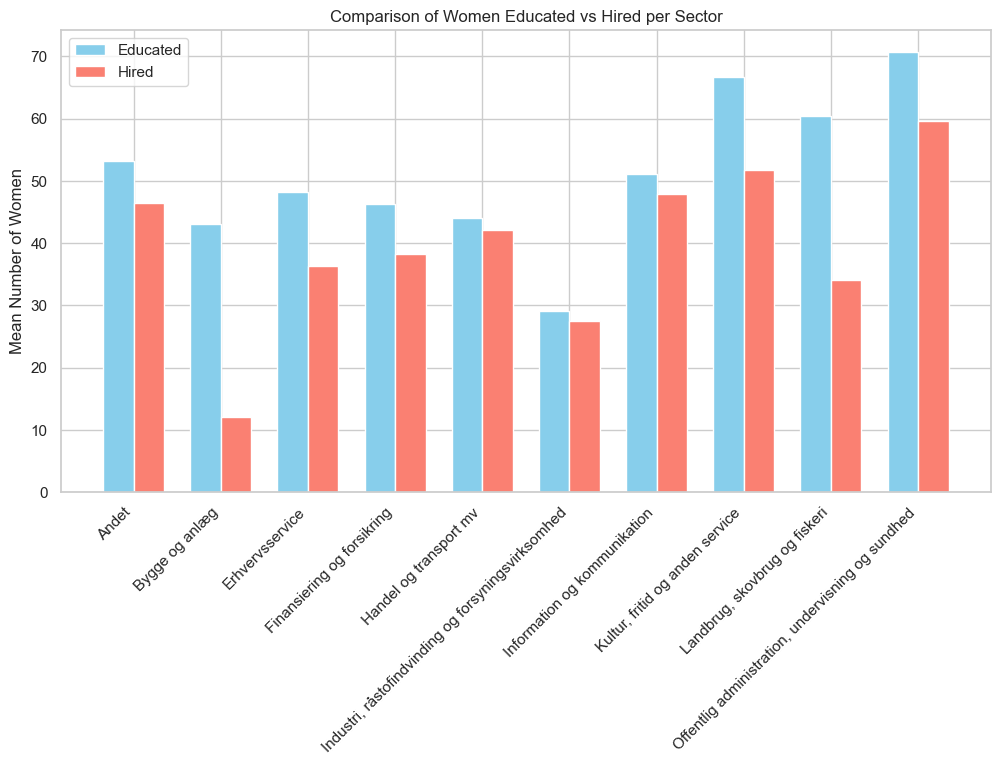

In [8]:
## Plot

# Sample data
data = {
    'Sector': ['Andet', 'Bygge og anlæg', 'Erhvervsservice', 'Finansiering og forsikring', 'Handel og transport mv', 'Industri, råstofindvinding og forsyningsvirksomhed', 'Information og kommunikation', 'Kultur, fritid og anden service', 'Landbrug, skovbrug og fiskeri', 'Offentlig administration, undervisning og sundhed'],
    'Educated': group_means["Andel kvinder 2020"],
    'Hired': mean_women["Women (per cent)"]
}

# Set style
sns.set(style="whitegrid")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
x = range(len(data['Sector']))

# Bars
ax.bar([i - bar_width/2 for i in x], data['Educated'], width=bar_width, label='Educated', color='skyblue')
ax.bar([i + bar_width/2 for i in x], data['Hired'], width=bar_width, label='Hired', color='salmon')

# Labels and ticks
ax.set_xticks(x)
ax.set_xticklabels(data['Sector'], rotation=45, ha='right')
ax.set_ylabel('Mean Number of Women')
ax.set_title('Comparison of Women Educated vs Hired per Sector')
ax.legend()

The comparison shown in the figure highlights the disparity between the proportion of women educated in different sectors and the proportion of women actually employed in those same sectors. While women often represent a significant share of those educated in many fields—including public administration, healthcare, education, and even some technical areas—they are underrepresented in the workforce, especially in sectors such as industry, construction, and business services.

It’s important to note that the classification of educational programs and job sectors used here is based on a custom mapping tailored for this analysis, aligning degrees and occupations into broader industry categories to enable comparison. Furthermore, multiple societal factors can influence this gap. For instance, women may take more extended career breaks for maternity leave, or opt for part-time roles due to caregiving responsibilities. However, these factors alone may not fully explain the underrepresentation.

Studies have consistently shown that women tend to achieve slightly higher grades than men across all levels of education. A large-scale meta-analysis by Voyer and Voyer (2014)(*) found that females have earned higher school grades than males for nearly a century, particularly in language and social sciences, but also in many STEM subjects. This trend is also reflected in Danish education statistics.

Furthermore, according to Statistics Denmark (2022)(**), women are more likely than men to complete higher education. In the 30–35 age group, over half of women (51.2%) have a higher education, compared to just 36.4% of men.

These findings indicate that the observed gap between education and employment cannot be explained by academic ability or achievement. Instead, it raises questions about other factors that may contribute, such as bias in hiring practices or gendered wording in job descriptions. Are there hidden barriers, such as biased job descriptions, that deter qualified women from applying or being selected? 


(*) Voyer, D., & Voyer, S. D. (2014). Gender differences in scholastic achievement: A meta-analysis. Psychological Bulletin, 140(4), 1174–1204.

(**) Statistics Denmark. (2022). Uddannelsesgabet mellem kvinder og mænd øges. Retrieved April 13, 2025, from https://www.dst.dk/da/Statistik/nyheder-analyser-publ/nyt/NytHtml?cid=38257

## Bias-detection

In the context of job advertisements, unconscious bias often manifests subtly through the language and structure used when describing roles. For example, job titles such as chairman, fireman, or councilman implicitly suggest a preference for male applicants, potentially deterring other qualified candidates. Similarly, the choice of pronouns can introduce bias; using gendered pronouns like he or she rather than gender-neutral alternatives like they or directly addressing the candidate as you can unintentionally reinforce gender stereotypes.

Biased language also appears when describing the ideal candidate. Terms like assertive or competitive tend to align with stereotypically masculine traits, while adjectives such as bubbly or nurturing typically associate with femininity. Additionally, overly detailed job requirements may disproportionately discourage women, who statistically are more likely to apply only if they meet all stated criteria, thereby limiting the applicant pool.

**Recognizing these issues, this study specifically focuses on addressing unconscious bias in hiring by examining the effects of biased language in job descriptions.**

### Preprocessing and extraction of frequent words

While the original plan was to apply classical topic modeling methods, such as Latent Dirichlet Allocation (LDA), preliminary exploration revealed that the raw job description data contained substantial amounts of administrative phrasing, web scraping artifacts, and repetitive generic language.  
As a result, direct topic modeling would not yield meaningful insights without significant data cleaning.

Instead, a structured text preprocessing approach was adopted.  
The goal is to extract the most **frequent, meaningful words** from job postings within **male-dominated** and **female-dominated industries** separately.  
This enables a focused identification of potential **gendered language patterns** that could reflect underlying biases in how different industries advertise roles.

The following code performs:
- Preprocessing of job descriptions (lowercasing, tokenization, and cleaning),
- Removal of standard Danish stopwords and additional domain-specific neutral terms,
- Filtering out irrelevant, non-content words (e.g., locations, administrative phrases),
- Extraction and counting of the most common content-bearing words for each group.

This approach provides a clear, interpretable alternative to traditional topic modeling, aligning closely with the study’s aim of uncovering unconscious bias through the analysis of job advertisement language.


In [46]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords

# Load Danish word list from .dic file
danish_words_path = 'Danish.dic'

danish_words = set()

with open(danish_words_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Read dictionary words
for line in lines[1:]:
    word = line.strip().split('/')[0].lower()
    if word:  
        danish_words.add(word)

print(f"Loaded {len(danish_words)} Danish words.")


df = pd.read_csv('job_descriptions_final.csv', sep=';', quoting=1)

user_gender_mapping = {0: 'male-dominated', 1: 'female-dominated'}
df['field_gender_user'] = df['Male or female'].map(user_gender_mapping)

# Danish stopwords
danish_stopwords = set(stopwords.words('danish'))


# Custom extra stopwords
custom_stopwords = danish_stopwords.union({
    'indeed', 'dk', 'https', 'com', 're', 'ans', 'from', 'viewjob', 'in', 'the', 
    'st', 'to', 'jk', 'ger', 'hj', 'tter', 'stillingen', 'arbejde', 'job', 'del',
    'vores', 'kan', 'kommune', 'arbejder', 'gode', 'tv', 'fokus', 'samt',
    'mere', 'ved', 'godt', 'forbindelse', 'side', 'lp', 'opret', 'udvikling',
    'mulighed', 'skabe', 'lande', 'and', 'erfaring', 'dine', 'website',
    'konto', 'god', 'bende', 'danmark', 'team', 'samarbejde', 'fuldtid', 
    'tilbyder', 'arbejdsplads', 'rapportering', 'sammen', 'se', 'kollegaer', 
    'pr', 'velkommen', 'dit', 'inden', 'hverdag', 'via', 'glostrup',
    'maj', 'dansk', 'kontakte', 'derfor', 'gerne', 'hele', 'andre', 'stor', 
    'cv', 'ring', 'as', 'will', 'region', 'via', 'plads', 'timer', 'maj', 
    'albertslund', 'rende', 'are', 'is', 'kommer', 'forst', 'mellem', 'ballerup', 
    'roskilde', 'center', 'tid', 'ser', 'baggrund', 'overenskomst', 'virksomhed', 
    'fordel', 'kolleger', 'kollega', 'hver', 'permanent', 'så'
})


def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-ZæøåÆØÅ]+', ' ', text)  # Keep Danish letters
    tokens = text.split()
    tokens = [word for word in tokens if word in danish_words and word not in custom_stopwords and len(word) > 1]
    return tokens


df['tokens'] = df['description'].apply(preprocess_text)


male_tokens = df[df['field_gender_user'] == 'male-dominated']['tokens'].sum()
female_tokens = df[df['field_gender_user'] == 'female-dominated']['tokens'].sum()

# Word frequencies
male_word_counts = Counter(male_tokens)
female_word_counts = Counter(female_tokens)

# Top words
N = 20
top_male_words = male_word_counts.most_common(N)
top_female_words = female_word_counts.most_common(N)

# Output
print("\nTop words in male-dominated industries:")
for word, count in top_male_words:
    print(f"{word}: {count}")

print("\nTop words in female-dominated industries:")
for word, count in top_female_words:
    print(f"{word}: {count}")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kalleleander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kalleleander/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kalleleander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loaded 149756 Danish words.

Top words in male-dominated industries:
sikre: 68
ansvar: 52
it: 48
service: 44
kvalitet: 38
transport: 37
uddannelse: 35
faglig: 35
indenfor: 33
kendskab: 33
rolle: 32
ende: 31
prim: 31
teknisk: 31
aarhus: 31
udvikle: 30
bedste: 30
klar: 30
industri: 29
trives: 29

Top words in female-dominated industries:
faglig: 61
sygeplejerske: 51
lyst: 47
trivsel: 40
ansvar: 39
leder: 36
skole: 36
unge: 36
stilling: 32
undervisning: 31
administration: 29
tilgang: 27
uddannelse: 27
psykiatri: 27
sparring: 27
bidrage: 26
trives: 26
telefon: 26
underviser: 26
henhold: 26


The extracted top words reveal some thematic differences between male- and female-dominated industries:

- In **male-dominated industries**, common words emphasize skills, responsibility, and standards, including terms like **sikre** (ensure), **ansvar** (responsibility), **kvalitet** (quality), and **udvikle** (develop).

- In **female-dominated industries**, common words more often relate to care professions, education, and wellbeing, featuring terms such as **trivsel** (wellbeing), **lyst** (desire/motivation), and **sparring** (coaching/support).

Both groups also share some neutral professional terms such as **faglig** (professional competence), **uddannelse** (education), and **ansvar** (responsibility), highlighting that leadership and professionalism are emphasized across industries, but with different contextual focuses. 

Notably, however, terms like **ansvar** and **uddannelse** are relatively more frequent in male-oriented postings.  
This suggests a greater emphasis on **performance**, **skills acquisition**, and **professional advancement** in the language used when attracting male applicants.

These findings suggest that job advertisement language may reflect broader gendered expectations and cultural norms about desired applicant traits.

Based on the studies of Gaucher et al. and similar, non gender-neutral words have been collected. Some words have been reduced to a 'stem' to cover a range of noun, verb and adjective variants; for instance "compet" covers "compete", "competetive" and "competition".

**Feminine-coded words**

| agree- | affectionate- | child-       | cheer-      | collab-     | commit-     |
|--------|----------------|--------------|-------------|-------------|-------------|
| communal- | compassion- | connect-     | considerate-| cooperat-   | co-operat-  |
| depend-   | emotiona-   | empath-      | feel-       | flatterable-| gentle-     |
| honest-   | interpersonal- | interdependen- | interpersona- | inter-personal- | inter-dependen- |
| inter-persona- | kind- | kinship-     | loyal-      | modesty-    | nag-        |
| nurtur-   | pleasant-   | polite-      | quiet-      | respon-     | sensitiv-   |
| submissive- | support- | sympath-     | tender-     | together-   | trust-      |
| understand- | warm-     | whin-        | enthusias-  | inclusive-  | yield-      |
| share-     | sharin-    |              |             |             |             |

**Masculine-coded words**

| active- | adventurous- | aggress-     | ambitio-    | analy-      | assert-     |
|---------|---------------|--------------|-------------|-------------|-------------|
| athlet- | autonom-     | battle-      | boast-      | challeng-   | champion-   |
| compet- | confident-   | courag-      | decid-      | decision-   | decisive-   |
| defend- | determin-    | domina-      | dominant-   | driven-     | fearless-   |
| fight-  | force-       | greedy-      | head-strong-| headstrong- | hierarch-   |
| hostil- | impulsive-   | independen-  | individual- | intellect-  | lead-       |
| logic-  | objective-   | opinion-     | outspoken-  | persist-    | principle-  |
| reckless- | self-confiden- | self-relian- | self-sufficien- | selfconfiden- | selfrelian- |
| selfsufficien- | stubborn- | superior- | unreasonab- |             |             |

**Gender neutral words**

Finde neutrale ord og synonymer man kan bruge i sted for de Feminine-coded og Masculine-coded ord, enten find synonymer som ikke er med på nogen af listene, eller bruge ord fx her fra: https://blog.ongig.com/diversity-and-inclusion/gender-neutral-adjectives/. 

### Bias-detection system

In [15]:
# THIS IS WHERE TO BEGIN CODING

# ONLY EXAMPLES THIS SHOULD BE SWITCHED OUT WITH THE REAL WORDS WE FIND (biased words and their neutral synoyms)
biased_synonyms = {
    "dominant": ["confident", "strong leadership"],
    "competitive": ["ambitious", "goal-oriented"],
    "nurturing": ["supportive", "team-oriented"],
    "aggressive": ["proactive", "assertive"]
}

In [16]:
stemmer = PorterStemmer()

def stem_words(words):
    return [stemmer.stem(word.lower()) for word in words]

def detect_biased_words_synonyms(text, biased_dict):
    # Tokenize and stem job description
    text_tokens = re.findall(r'\b\w+\b', text.lower())
    text_stems = stem_words(text_tokens)

    # Prepare stemmed version of the biased dictionary
    stemmed_biased_dict = {stemmer.stem(k.lower()): (k, v) for k, v in biased_dict.items()}

    results = []
    for idx, stem in enumerate(text_stems):
        if stem in stemmed_biased_dict:
            original_word = text_tokens[idx]
            biased_word, alternatives = stemmed_biased_dict[stem]
            results.append({
                "matched_word": original_word,
                "biased_word": biased_word,
                "suggestions": alternatives
            })

    return results

In [17]:
text = """
We are looking for a dominant and aggressive leader who is highly competitive and nurturing
to younger staff.
"""

output = detect_biased_words_synonyms(text, biased_synonyms)

for item in output:
    print(f"Found: '{item['matched_word']}' → Suggest: {item['suggestions']}")

Found: 'dominant' → Suggest: ['confident', 'strong leadership']
Found: 'aggressive' → Suggest: ['proactive', 'assertive']
Found: 'competitive' → Suggest: ['ambitious', 'goal-oriented']
Found: 'nurturing' → Suggest: ['supportive', 'team-oriented']


In [21]:
# Load CSV
df = pd.read_csv("job_descriptions.csv")  

# Apply detection function for each job description
def analyze_jobs(df, biased_synonyms):
    results = []

    for idx, row in df.iterrows():
        title = row["title"]
        description = row["description"]

        output = detect_biased_words_synonyms(description, biased_synonyms)

        results.append({
            "Job Title": title,
            "Biased Words Found": output
        })

    return results

# Run the analysis
job_results = analyze_jobs(df, biased_synonyms)

# Print the results
for job in job_results:
    print(f"🔹 Job Title: {job['Job Title']}")
    if job['Biased Words Found']:
        for item in job['Biased Words Found']:
            print(f"  - Found: '{item['matched_word']}' → Suggest: {item['suggestions']}")
    else:
        print("  - No biased words found.")
    print("-" * 50)

🔹 Job Title: Teamleder til drift af Køge Kraftvarmeværk Ny
  - No biased words found.
--------------------------------------------------
🔹 Job Title: Studentermedhjælper i Administrationen hos Specialisterne
  - No biased words found.
--------------------------------------------------
🔹 Job Title: Servicetekniker
  - No biased words found.
--------------------------------------------------
🔹 Job Title: Attraktiv stilling som lærer på Ådal Skole afd. Slagslunde
  - No biased words found.
--------------------------------------------------
🔹 Job Title: Maskiningeniør, Vejen
  - No biased words found.
--------------------------------------------------
🔹 Job Title: Praktikant inden for transport
  - No biased words found.
--------------------------------------------------
🔹 Job Title: Specialiseret lærer til vores Gruppeordning
  - No biased words found.
--------------------------------------------------
🔹 Job Title: O"shore Servicetekniker
  - No biased words found.
-----------------------

### Bias detection system using contextual embedding + similarity

After applying the lexicon-based bias detection algorithm, it is valuable to enhance the detection process using a semantic model. By embedding both the sentences of the job descriptions and the predefined bias terms, we can leverage semantic similarity to identify potential bias in job descriptions. This is achieved by computing the cosine similarity between the sentence embeddings and the bias term embeddings.

For each sentence in a job description, the cosine similarity score is compared to a pre-defined threshold. If the score exceeds this threshold, the sentence is labeled as "potentially biased." The threshold is adjustable based on experimentation and evaluation, allowing flexibility in detecting bias at different sensitivity levels.

However, it's important to note a few limitations of this approach:

* Lack of Contextual Sensitivity: The model does not understand the context in which the bias terms are used. For example, if a job description mentions "young people," and the bias term list contains the word "youthful," the sentence will be flagged as biased based solely on the similarity to the term "youthful". This does not account for whether "youthful" refers to actual youth, or if it is used in a different context entirely.

* False Positives: Since the function compares word embeddings directly, there is a possibility that sentences may be wrongly flagged as biased even if they do not express discriminatory intent. For example, a sentence may contain the word "leader" in a neutral context, but if the bias term "natural leader" is part of the bias lexicon, the sentence might still be flagged. This emphasizes that the model cannot capture all nuances in language and context.

* Manual Verification: As a result of the above limitations, any sentence flagged as potentially biased should be manually reviewed. It is essential to determine whether the flagged sentence truly reflects a biased statement or if the word appears in a different context that is not discriminatory. The function’s role is to highlight potential bias; it cannot make final judgments regarding the presence of bias without human oversight.

In [22]:
# Example bias terms and job description, should be replaced
bias_terms = ["dominerende", "aggressiv", "rockstjerne", "ungdommelig", "naturlig leder"]

In [23]:
def context_analysis(df, bias_terms, title_col="title", desc_col="description", threshold=0.5):
    """
    Detects potential bias in job descriptions based on semantic similarity to bias terms.

    Args:
        df (DataFrame): A pandas DataFrame with columns "title" and "description".
        bias_terms (list of str): List of bias words/phrases to detect.
        threshold (float): Cosine similarity threshold to flag potential bias.

    Returns:
        results (list of dict): Each dict contains job title, biased sentence, matched terms, and score.
    """

    # Load sentence-transformer model
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

    results = []

    # Precompute embeddings for bias terms
    bias_embeddings = model.encode(bias_terms, convert_to_tensor=True)

    # Loop through each job description
    for idx, row in df.iterrows():
        title = row["title"]
        description = row["description"]

        # Skip missing descriptions
        if pd.isna(description) or description.strip() == "":
            continue

        # Split into sentences
        all_sentences = sent_tokenize(description)

        # Embed all sentences
        sentence_embeddings = model.encode(all_sentences, convert_to_tensor=True)

        # Compute cosine similarities: (num_sentences x num_bias_terms)
        cosine_scores = util.cos_sim(sentence_embeddings, bias_embeddings)

        # Check each sentence separately
        for i, sentence in enumerate(all_sentences):
            # Skip sentences too short to be meaningful
            if len(sentence.split()) < 5 or len(sentence) < 30:
                continue
            
            # Get the cosine similarity scores for the current sentence
            scores = cosine_scores[i]

            # Check if any score exceeds the threshold
            matched_indices = (scores > threshold).nonzero(as_tuple=True)[0]

            # If there are any matches, store the results
            if len(matched_indices) > 0:
                matched_terms = [bias_terms[j] for j in matched_indices]
                results.append({
                    "Job Title": title,
                    "Potential Bias in": sentence,
                    "Matched terms": matched_terms,
                    "Max Score": torch.max(scores).item()
                })

    return results



In [24]:
def results_to_dataframe(results):
    records = []
    for r in results:
        record = {
            "Job Title": r["Job Title"],
            "Potential Bias Sentence": r["Potential Bias in"],
            "Matched Terms": ", ".join(r["Matched terms"]),
            "Max Similarity Score": r["Max Score"]
        }
        records.append(record)
    return pd.DataFrame(records)

results = context_analysis(df, bias_terms, title_col="Job Title", desc_col="Job Description")
# Print results
print("Results of Contextual Embedding and Similarity for Bias Detection:")
""" for job in results:
    print(f"🔹 Job Title: {job['Job Title']}")
    if job['Potential Bias in']:
        print(f"  - Potential Bias in: '{job['Potential Bias in']}'")
        print(f"  - Matched terms: {job['Matched terms']}")
        print(f"  - Max Score: {job['Max Score']}")
    else:
        print("  - No biased words found.")
    print("-" * 50) """

# Convert semantic similarity results to DataFrame
nltk.download('punkt')
df_results = results_to_dataframe(results)
display(df_results.head())


Results of Contextual Embedding and Similarity for Bias Detection:


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kalleleander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Job Title,Potential Bias Sentence,Matched Terms,Max Similarity Score
0,To juridiske chefer med strategisk overblik og...,Erfaring med ledelse – gerne strategisk ledels...,naturlig leder,0.543166
1,Underviser søges til ZBC10 i Næstved,Vi tilbyder et job med: Mulighed for at gøre e...,ungdommelig,0.546031
2,Erfaren sygeplejerske med lyst til nattevagt,En nærværende og tilgængelig leder der har fok...,naturlig leder,0.595171
3,Motiveres du af relationsarbejde med unge? Bliv,Velkommen indenfor på afsnit B203 Vi er et åbe...,ungdommelig,0.544818
4,Motiveres du af relationsarbejde med unge? Bliv,I samarbejde med den unge er din opgave som ko...,ungdommelig,0.535596


### Sentence-level Bias Classifier
After identifying sentences in job descriptions that are labeled as biased based on the bias terms both directly using lexicon-based detection and semantically using the contextual embedding, the next step is to build a classifier that can recognize biased language even when specific bias terms or their synonyms do not appear directly in the text.

The primary goal of this classifier is to generalize beyond the predefined bias terms and detect subtle instances of bias that may not be captured by a lexicon-based approach. While lexicon-based detection rely on matching explicit words or phrases, a classifier can learn to recognize patterns and relationships in the language that indicate bias, regardless of whether the exact terms are used. This generalization ability allows the classifier to identify indirect forms of bias that might otherwise go unnoticed.

By using a classification model, we can train it on the labeled sentences (biased vs. non-biased) and enable it to learn the features and relationships between the text and the bias labels. The advantage of using this model is that it can process a wider range of language, recognizing biased language that does not rely solely on a pre-defined set of bias terms, and thus improving the overall detection accuracy.

The goal of the classifier is to train it to recognize bias in sentences, even if these sentences do not explicitly contain pre-defined bias terms. By achieving this, the classifier will be able to determine if any sentences in a job description is potentially bias.

We trained two models to detect potentially biased sentences in job descriptions: a Logistic Regression classifier and an XGBoost classifier, both using TF-IDF features and weak labels derived from a curated list of gender-coded words.

In [29]:
# Example bias terms and job description, should be replaced
bias_terms_weak_label = ["dominerende", "aggressiv", "ekstrovert", "ansvarlig", "naturlig leder", "faglig", "sikre", "bidrage"]

In [30]:
def label_data(df, bias_terms_weak_label, title_col="title", desc_col="description"):
    sentences = []
    labels = []

    # Loop through each job description
    for idx, row in df.iterrows():
        title = row[title_col]
        description = row[desc_col]

        # Skip missing descriptions
        if pd.isna(description) or description.strip() == "":
            continue

        # Correct: Split the WHOLE description into sentences
        for sentence in sent_tokenize(description):
            sentences.append(sentence)
            # Weak labeling: check if any bias term is in the sentence
            if any(bias_word in sentence.lower() for bias_word in bias_terms_weak_label):
                labels.append(1)
            else:
                labels.append(0)

    labeled_df = pd.DataFrame({'sentence': sentences, 'label': labels})
    return labeled_df

In [ ]:
df_labeled = label_data(df, bias_terms_weak_label, title_col="title", desc_col="description")

def classify_bias(df_labeled):
    # Convert text to TF-IDF features
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    X = vectorizer.fit_transform(df_labeled['sentence'])
    y = df_labeled['label']

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)

    #Cross-validation of the classifier
    #scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
    #cross_validation = {"F1 scores:", scores, "Mean F1:", scores.mean()}
    return classification_report(y_test, y_pred)

In [33]:
df_labeled = label_data(df, bias_terms_weak_label, title_col="title", desc_col="description")

In [ ]:
print("Potential Bias Results:")
print(classify_bias(df_labeled))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def classify_bias_rf(df_labeled, top_n_features=20):
    # Convert text to TF-IDF features
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X = vectorizer.fit_transform(df_labeled['sentence'])
    y = df_labeled['label']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Feature importance plot
    feature_names = vectorizer.get_feature_names_out()
    importances = clf.feature_importances_
    indices = np.argsort(importances)[-top_n_features:][::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n_features), importances[indices], align='center')
    plt.yticks(range(top_n_features), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n_features} TF-IDF Features (Random Forest)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


Potential Bias Results (Random Forest):
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       735
           1       1.00      0.83      0.91       110

    accuracy                           0.98       845
   macro avg       0.99      0.91      0.95       845
weighted avg       0.98      0.98      0.98       845



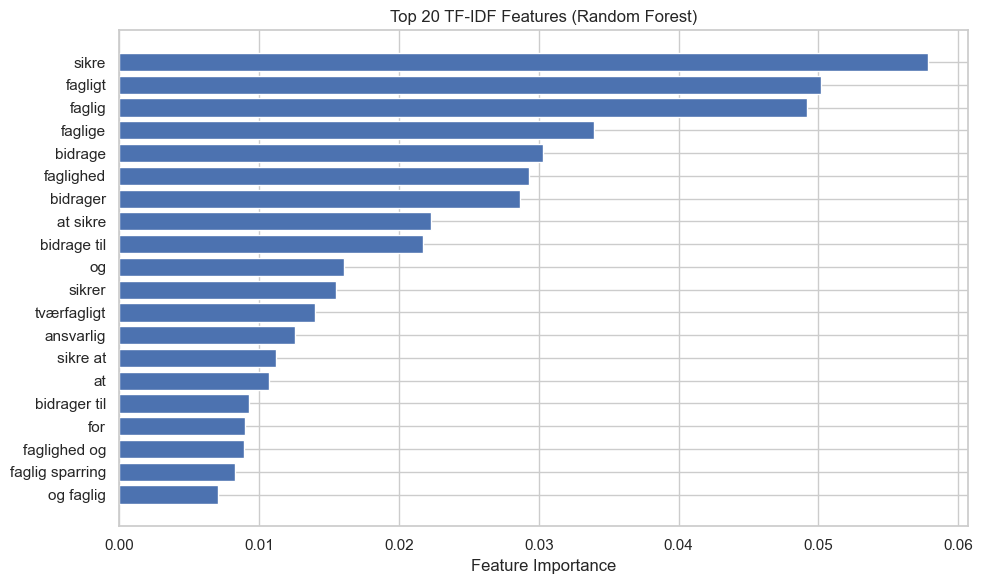

In [32]:
print("Potential Bias Results (Random Forest):")
classify_bias_rf(df_labeled)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import time

# Vectorize
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000, stop_words=list(custom_stopwords))
X = vectorizer.fit_transform(df_labeled["sentence"])
y = df_labeled["label"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and store predictions
trained_models = {}
predictions = {}
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start
    
    y_pred = model.predict(X_test)
    
    trained_models[name] = model
    predictions[name] = y_pred
    results[name] = {
        "time": duration,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }


Training Logistic Regression...
Training XGBoost...


/Users/kalleleander/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [48]:
from sklearn.metrics import classification_report

def print_model_results(results, predictions, y_test):
    for name in results:
        print(f"\nModel: {name}")
        print(f"Training time: {results[name]['time']:.2f}s")
        print(f"Accuracy: {results[name]['accuracy']:.3f}")
        print(f"F1 Score: {results[name]['f1']:.3f}")
        print("Classification Report:\n", classification_report(y_test, predictions[name]))

# Run this to print summary
print_model_results(results, predictions, y_test)



Model: Logistic Regression
Training time: 0.01s
Accuracy: 0.924
F1 Score: 0.590
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       735
           1       1.00      0.42      0.59       110

    accuracy                           0.92       845
   macro avg       0.96      0.71      0.77       845
weighted avg       0.93      0.92      0.91       845


Model: XGBoost
Training time: 0.06s
Accuracy: 0.991
F1 Score: 0.962
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       735
           1       1.00      0.93      0.96       110

    accuracy                           0.99       845
   macro avg       0.99      0.96      0.98       845
weighted avg       0.99      0.99      0.99       845



Logistic Regression was fast but rarely flagged bias, leading to low recall (missed many biased sentences).

XGBoost was both accurate and balanced, achieving high recall and high precision on biased sentences meaning that the XGBoost classifier was much better at catching subtle bias in language while minimizing false positives.

Given the performance of XGBoost, we chose it as our final model for sentence-level bias classification. It balances fairness and accuracy, making it a better fit for bias detection applications.

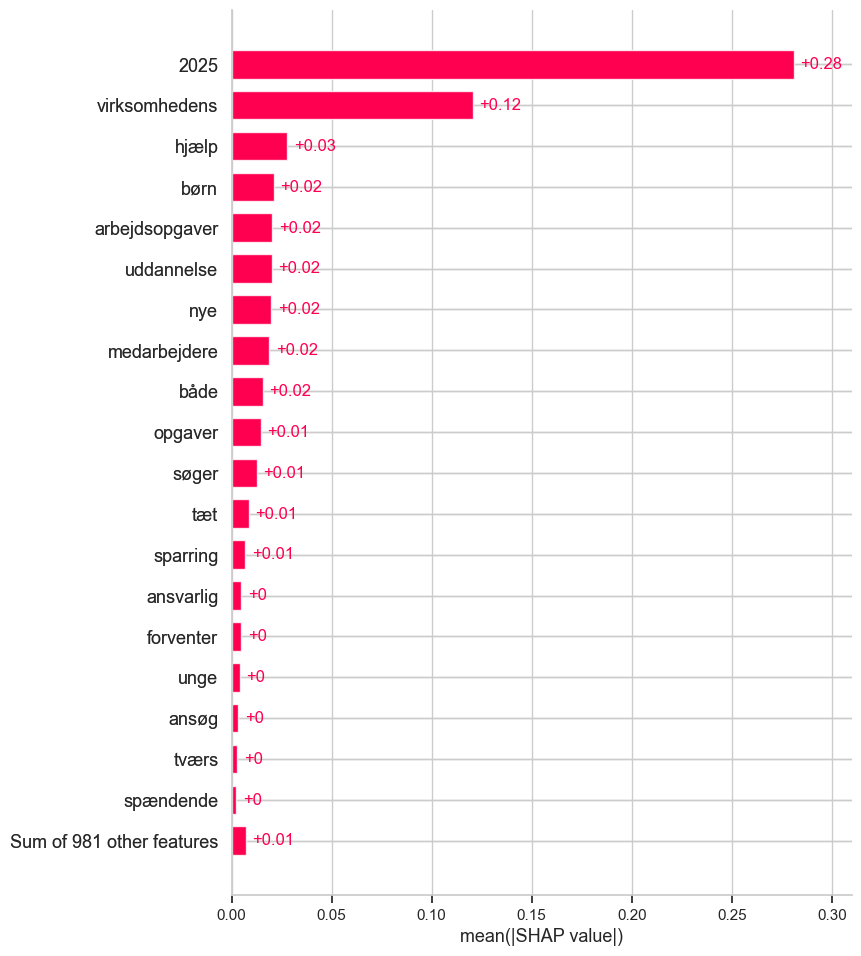

In [49]:
import shap

# Use the same model and vectorizer
xgb_model = trained_models["XGBoost"]
feature_names = vectorizer.get_feature_names_out()

# SHAP expects dense matrix (X is sparse)
X_dense = X_train.toarray()

# Create SHAP explainer and compute values
explainer = shap.Explainer(xgb_model, X_dense, feature_names=feature_names)
shap_values = explainer(X_dense)

# Global feature importance
shap.plots.bar(shap_values, max_display=20)


In [53]:
X_test_dense = X_test.toarray()
feature_names = vectorizer.get_feature_names_out()

X_test_disp = pd.DataFrame(X_test_dense, columns=feature_names)



In [54]:
import shap


explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_dense)

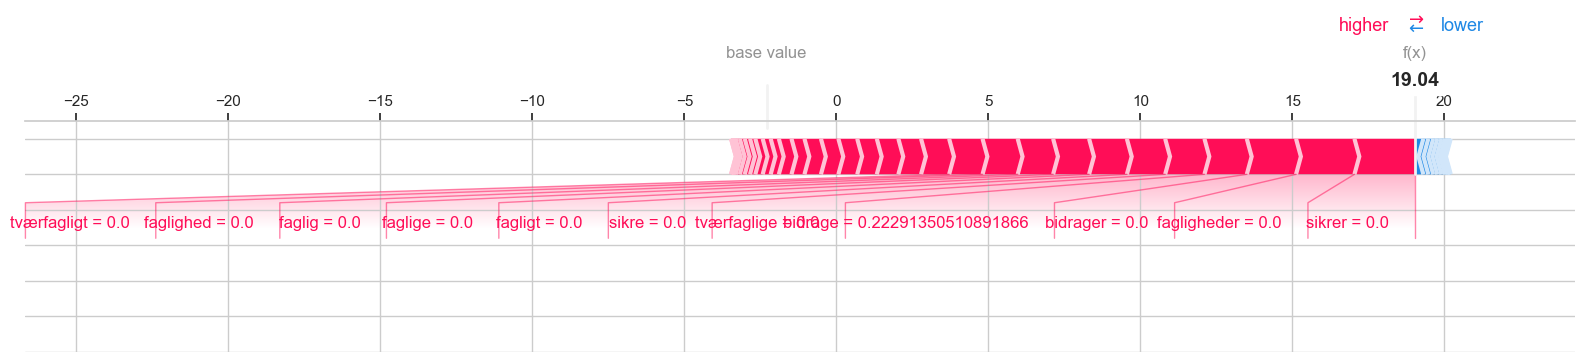

In [62]:
i = 5  # change this to try other examples

# Get values for that one prediction
shap_vals_row = shap_values[i]
features_row = X_test_disp.iloc[i]

# Filter only top contributing features
# You can set a threshold or limit the number of features
nonzero_idx = np.abs(shap_vals_row) > 0.001  # only show meaningful features
filtered_vals = shap_vals_row[nonzero_idx]
filtered_features = features_row[nonzero_idx]

# Create a shorter force plot
shap.force_plot(
    explainer.expected_value,
    filtered_vals,
    filtered_features,
    matplotlib=True
)

## Further work
A bias detection system, like the one developed in this project, has strong potential for real-world application in reducing unconscious bias in recruitment processes. Research shows that bias often enters already at the talent attraction phase, particularly through the language used in job advertisements, which can subtly favor or discourage certain groups. 

One direct application could be for organizations, such as DTU, to test their own recruitment materials by running their historical and current job descriptions through the model to identify patterns of bias. Although it was not possible within this project to obtain DTU’s own data for analysis, such internal testing would provide valuable insights into potential systemic issues. 

In practice, bias detection systems could be embedded directly into HR workflows: for instance, flagging potentially biased language before a job posting is published, or providing bias reduction suggestions automatically. Over time, organizations could also track changes in language use and measure whether interventions have improved inclusivity. 

Beyond recruitment, similar techniques could be applied to other organizational texts - such as promotion criteria, internal communications, and performance evaluations - helping foster a more diverse and equitable environment at multiple stages of the employee lifecycle.